# **Anomaly Detection - AE Experiment 7**

### Imports

In [1]:
import os
import zipfile
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, ConfusionMatrixDisplay)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


### Dataset 

Download the data from the onedrive folder and add the zipped folders to the Data/raw folder. Adjust the variable zip_filename to the zipped folder you want to use.

In [5]:
zip_filename = "../../Data/raw/11_synthetic_anomalies.zip"         # Path to your zipped file in the repo
extract_dir = "../../Data/raw"             # Destination folder where data should be extracted

In [ ]:
# Only unzip if the folder is not already there
if not os.path.exists(os.path.join(extract_dir, "11_synthetic_anomalies")):
    print(f"Extracting {zip_filename} to {extract_dir}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction done.")

Extracting ../../Data/raw/11_synthetic_anomalies.zip to ../../Data/raw...
Extraction done.


In [10]:
# Paths to audio files
anomalous_audio_path = "../../Data/raw/11_synthetic_anomalies/A_09_10_experiment7_8.wav"
normal_audio_path = "../../Data/raw/11_synthetic_anomalies/N_09_experiment7.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/anomalous_frames.npy"
output_normal_frames_path = "../../Data/frames/normal_frames.npy"
train_frames_path = "../../Data/datasets/train_frames.npy"
val_frames_path = "../../Data/datasets/val_frames.npy"
test_frames_path = "../../Data/datasets/test_frames.npy"
test_labels_path = "../../Data/datasets/test_labels.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)

# 1. Data Preprocessing

### Mel-Spectrogram Generation

In [11]:
# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

In [12]:
# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)

In [72]:
# Ensure sampling rates match
assert sr_anomalous == sr_normal, "Sampling rates do not match!"

### Frame Generation

In [73]:
# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

In [74]:
# Adjustable parameters
time_per_frame = 0.6  # Duration of one frame in seconds
hop_ratio = 0.2       # Overlap ratio between frames

In [75]:
# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

In [76]:
# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

In [77]:
# Function to visualize a subset of frames for inspection
def plot_frames(frames, num_frames=5, title_prefix="Frame"):
    num_frames = min(num_frames, len(frames))
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[i], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Visualizing frames for anomalous sounds...


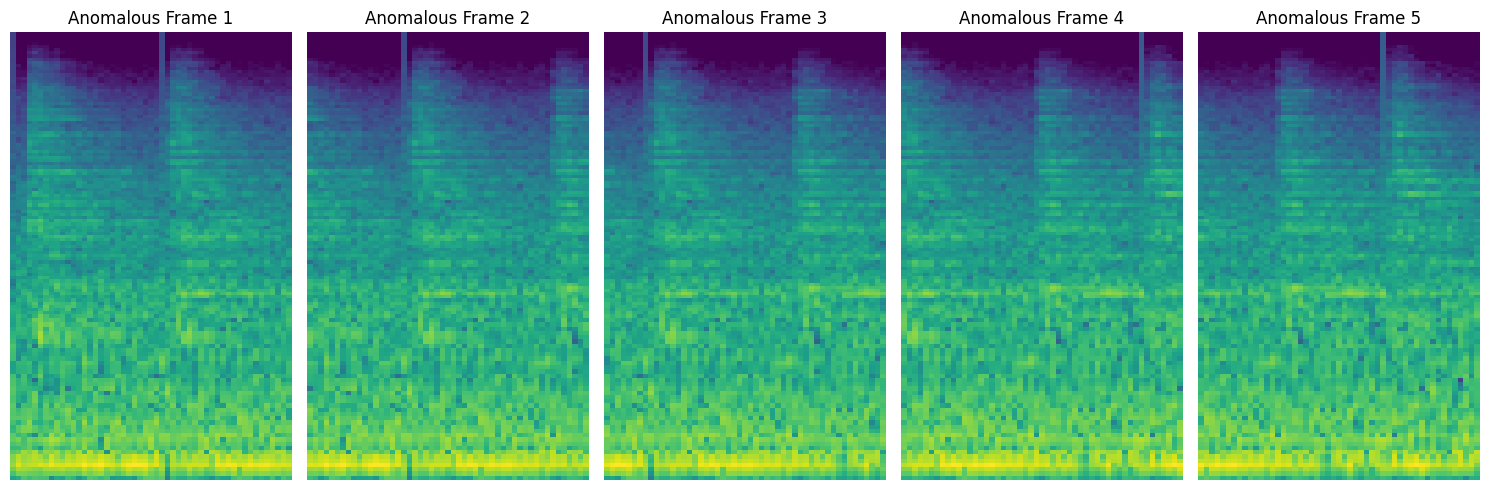

In [78]:
# Visualize anomalous frames
print("Visualizing frames for anomalous sounds...")
plot_frames(anomalous_frames, num_frames=5, title_prefix="Anomalous Frame")

Visualizing frames for normal sounds...


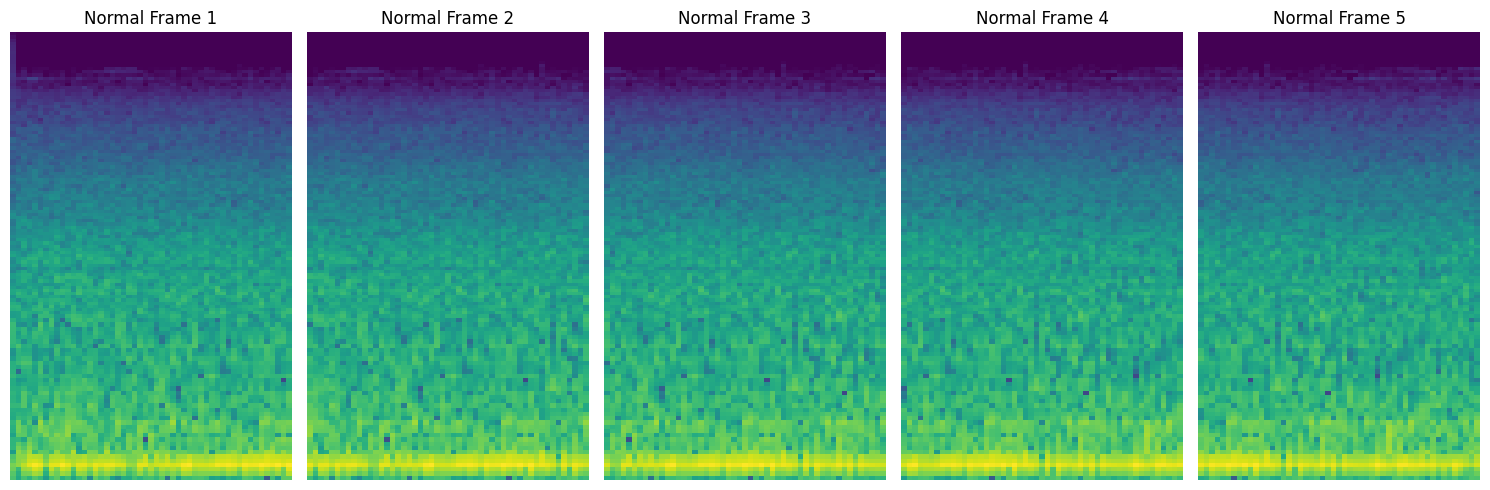

In [79]:
# Visualize normal frames
print("Visualizing frames for normal sounds...")
plot_frames(normal_frames, num_frames=5, title_prefix="Normal Frame")

In [80]:
# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)

### Train and Test Splitting

In [81]:
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split normal frames into training, validation, and test sets
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)  # Approximately 15% of total normal data

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path, normal_val)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

# Load datasets for training
train_frames = np.load(train_frames_path)
val_frames = np.load(val_frames_path)

# Convert to PyTorch tensors
train_frames_tensor = torch.tensor(train_frames, dtype=torch.float32)
val_frames_tensor = torch.tensor(val_frames, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_frames_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_frames_tensor), batch_size=batch_size)

# 2. Autoencoder Model

In [82]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        flattened_size = input_shape[0] * input_shape[1]
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, flattened_size),
            nn.Sigmoid(),
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 3. Training

In [83]:
# Initialize the model
input_shape = train_frames_tensor.shape[1:]
autoencoder = Autoencoder(input_shape)

In [84]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

In [85]:
# Training loop with loss tracking
epochs = 6
train_losses = []
val_losses = []

for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for inputs in train_loader:
        inputs = inputs[0]  # Unpack the tuple
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs[0]  # Unpack the tuple
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/6, Training Loss: 0.0575, Validation Loss: 0.0511
Epoch 2/6, Training Loss: 0.0339, Validation Loss: 0.0164
Epoch 3/6, Training Loss: 0.0085, Validation Loss: 0.0040
Epoch 4/6, Training Loss: 0.0030, Validation Loss: 0.0025
Epoch 5/6, Training Loss: 0.0024, Validation Loss: 0.0023
Epoch 6/6, Training Loss: 0.0022, Validation Loss: 0.0022


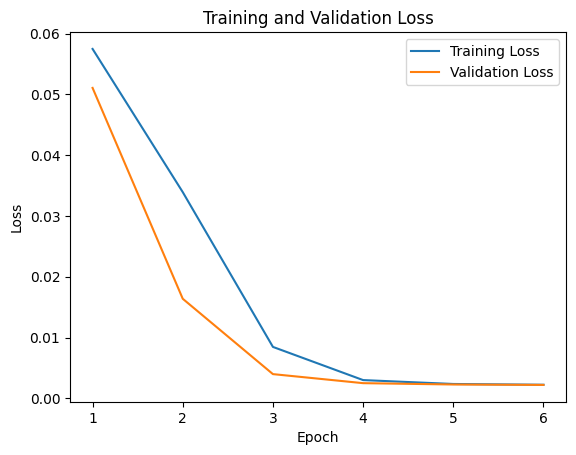

Autoencoder model saved to autoencoder_model.pth


In [86]:
# Plot training and validation loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")
print("Autoencoder model saved to autoencoder_model.pth")

# 4. Anomalie Detection

### Threshold Setting

In [87]:
# Load test frames and labels
test_frames = np.load(test_frames_path)
test_labels = np.load(test_labels_path)

# Convert test frames to PyTorch tensor
test_frames_tensor = torch.tensor(test_frames, dtype=torch.float32)

# Load the trained autoencoder model
autoencoder.load_state_dict(torch.load("autoencoder_model.pth"))
autoencoder.eval()

# Compute reconstruction errors on the validation set
with torch.no_grad():
    val_reconstructions = autoencoder(val_frames_tensor)
    val_losses_tensor = nn.functional.mse_loss(val_reconstructions, val_frames_tensor, reduction='none')
    val_losses = val_losses_tensor.view(val_losses_tensor.size(0), -1).mean(dim=1).numpy()

# Set threshold based on validation losses
threshold = np.percentile(val_losses, 96)
print(f"Threshold for anomaly detection set at: {threshold}")


C:\Users\s.krummenacher\AppData\Local\Temp\ipykernel_22436\2049680361.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("autoencoder

Threshold for anomaly detection set at: 0.0024786959402263165


### Anomaly Prediction

In [88]:
# Compute reconstruction errors on the test set
with torch.no_grad():
    test_reconstructions = autoencoder(test_frames_tensor)
    test_losses_tensor = nn.functional.mse_loss(test_reconstructions, test_frames_tensor, reduction='none')
    test_losses = test_losses_tensor.view(test_losses_tensor.size(0), -1).mean(dim=1).numpy()

In [89]:
# Predict anomalies
predictions = (test_losses > threshold).astype(int)

### Evaluation

In [90]:
# Evaluate performance
roc_auc = roc_auc_score(test_labels, test_losses)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
conf_matrix = confusion_matrix(test_labels, predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.9989
Precision: 0.9734, Recall: 0.9967, F1-Score: 0.9849
Confusion Matrix:
[[ 941   49]
 [   6 1794]]


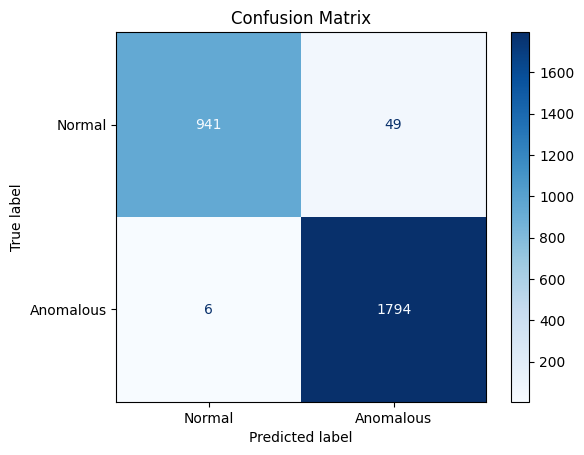

In [91]:
# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

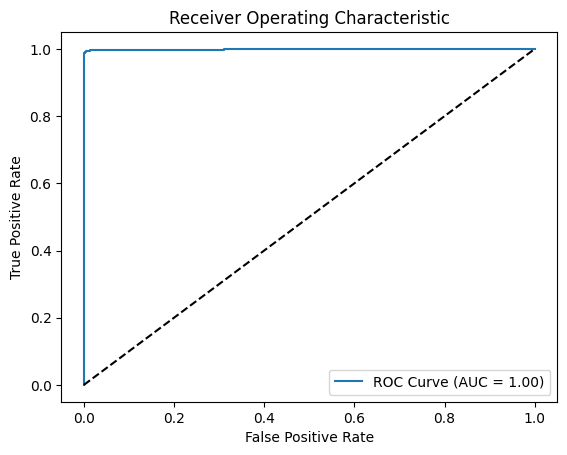

In [92]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_losses)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Correctly Classified Anomalies:


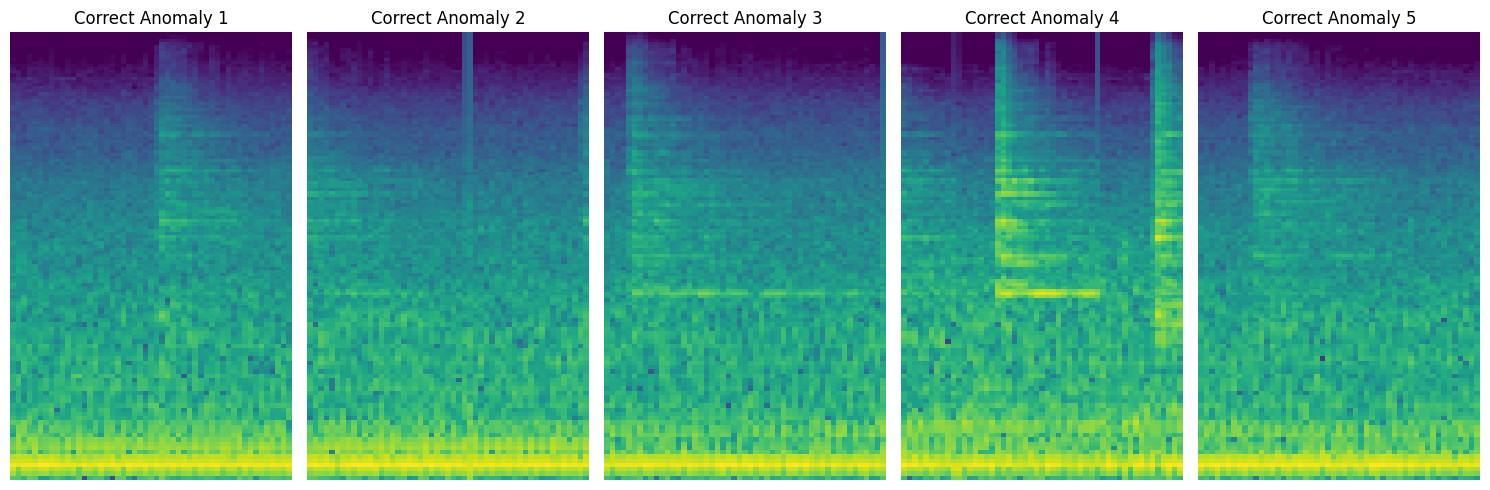

Wrongly Classified Anomalies:


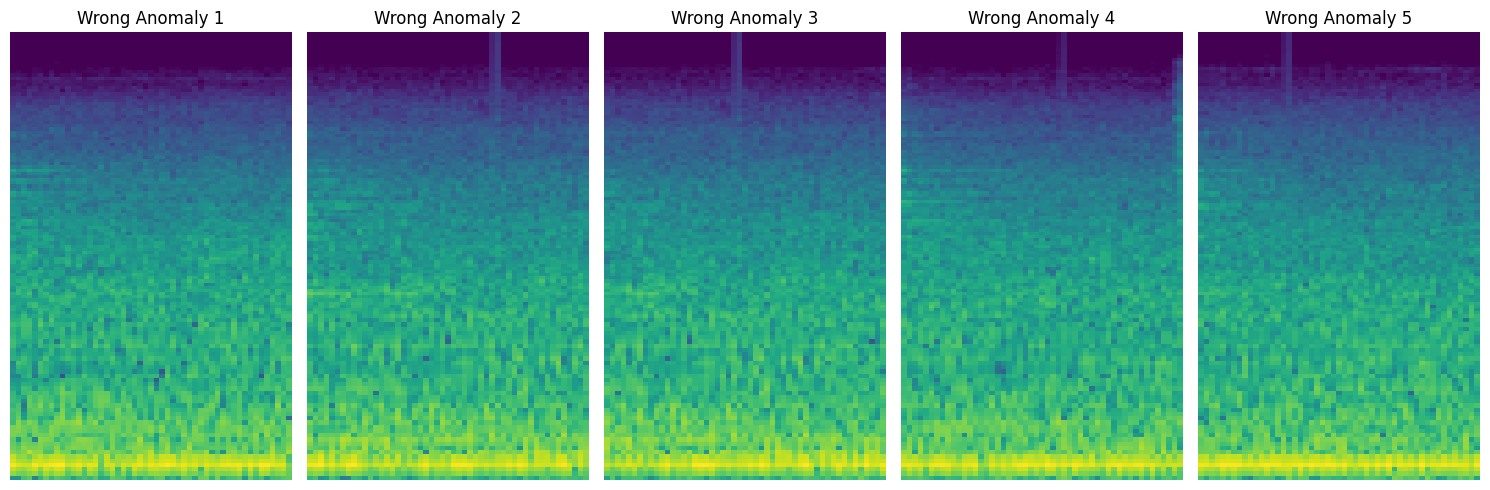

Wrongly Classified Normal Frames:


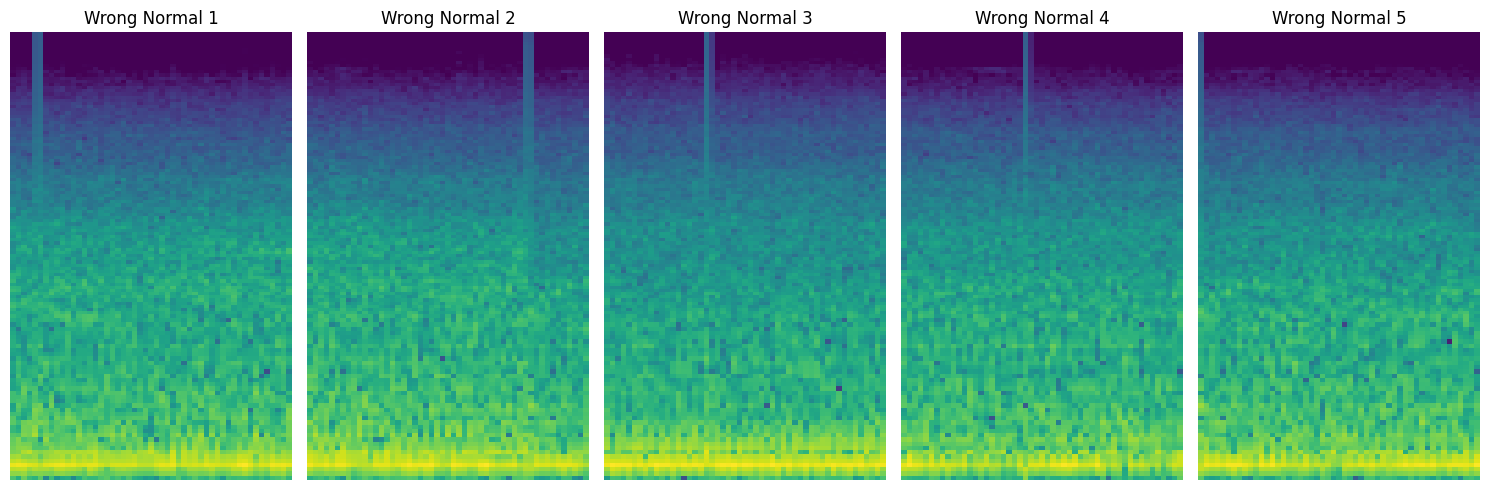

In [93]:
# Identify indices
correctly_classified_anomalies = np.where((test_labels == 1) & (predictions == 1))[0]
wrongly_classified_anomalies = np.where((test_labels == 1) & (predictions == 0))[0]
wrongly_classified_normals = np.where((test_labels == 0) & (predictions == 1))[0]

# Select up to 5 samples from each category
num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

# Function to plot specified frames
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, idx in enumerate(indices):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Plot 5 correctly classified anomalies
print("Correctly Classified Anomalies:")
plot_specified_frames(test_frames, correct_anomaly_indices, title_prefix="Correct Anomaly")

# Plot 5 wrongly classified anomalies
print("Wrongly Classified Anomalies:")
plot_specified_frames(test_frames, wrong_anomaly_indices, title_prefix="Wrong Anomaly")

# Plot 5 wrongly classified normal frames
print("Wrongly Classified Normal Frames:")
plot_specified_frames(test_frames, wrong_normal_indices, title_prefix="Wrong Normal")

In [94]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt
from matplotlib import ticker

import librosa.display
import numpy as np
import os

## **1. Loading MEL Scales**

1.1. 10_experiment8_5tesMic_Schaufel_rumlaufen

In [95]:
# Paths to your audio files in the aligned folder
audio_exp8_path = "../Data/raw/11_A_09_experiment7/A_09_10_experiment7_8.wav"

# Load aligned audio files
audio_knock, sr1 = librosa.load(audio_exp8_path, sr=None)
print("audio_exp8 loaded.")

audio_exp8 loaded.


In [96]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_knock = librosa.stft(audio_knock, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [97]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock = librosa.power_to_db(mel_knock, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock = (mel_db_knock - np.mean(mel_db_knock)) / np.std(mel_db_knock)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/A_09_10_experiment7_8.npy", mel_db_knock)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


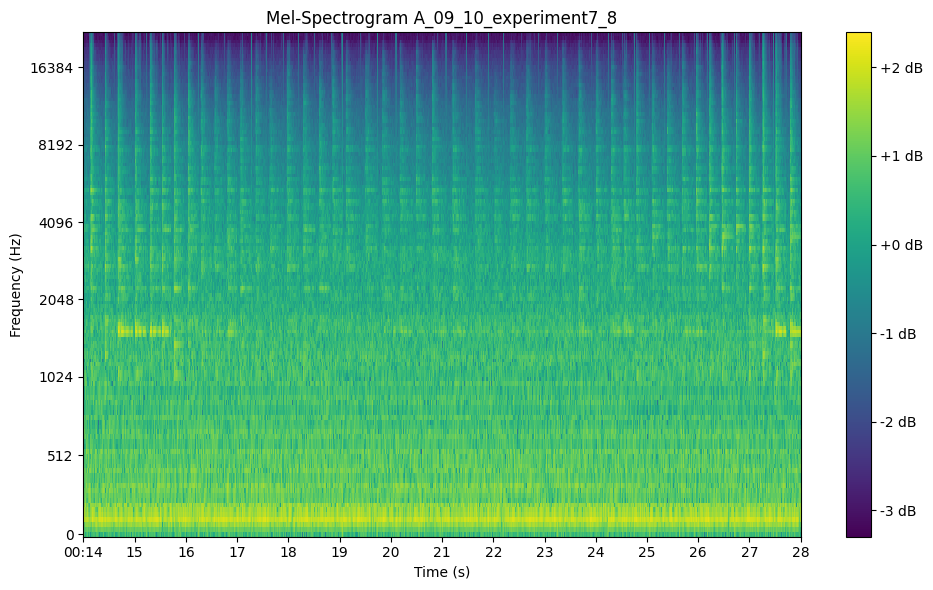

In [98]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram A_09_10_experiment7_8', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([14, 28])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_A_09_10_experiment7_8.png')
plt.show()

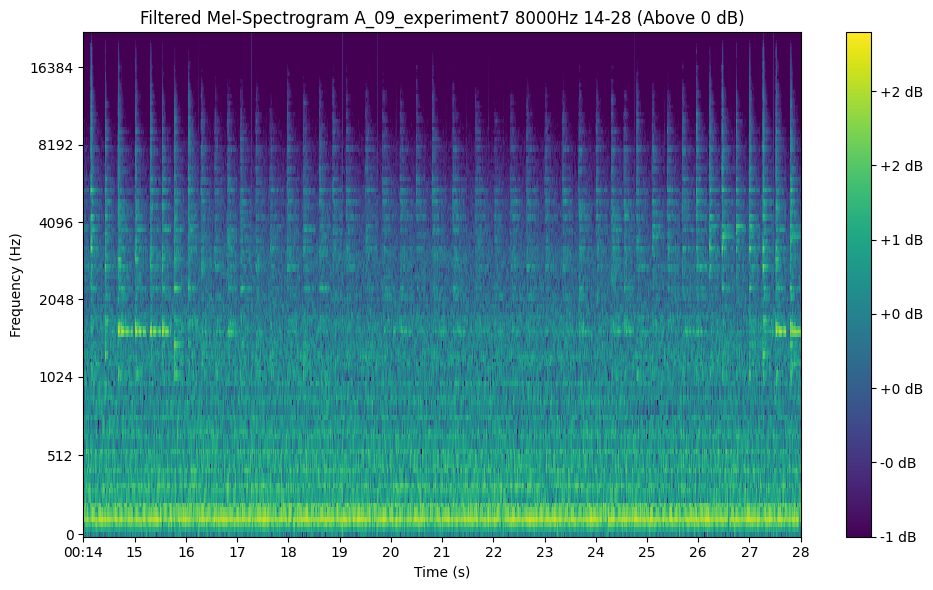

In [99]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax, vmin=-1)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram A_09_experiment7 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([14, 28])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img2, ax=ax, format='%+2.0f dB')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_A_09_10_experiment7_8_8000_filtered.png')
plt.show()

### Frames


In [100]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for anomalous Pi1 and Pi2
frames_Api1 = generate_frames(mel_db_knock)

print(f"Frames Api1 (Anomalous): {frames_Api1.shape}")


Frames Api1 (Anomalous): (280, 128, 128)


1.2. 08_livetest_knackgeräusch_output_MIC3

In [101]:
# Paths to your audio files in the aligned folder
audio_knock_path = "../Data/raw/08_livetest_knackgeräusch/output_MIC3_2024-11-07_13-55-04_968247.wav"

# Load aligned audio files
audio_knock, sr1 = librosa.load(audio_knock_path, sr=None)
print("audio_knock loaded.")

audio_knock loaded.


In [102]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_knock = librosa.stft(audio_knock, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [103]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock = librosa.power_to_db(mel_knock, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock = (mel_db_knock - np.mean(mel_db_knock)) / np.std(mel_db_knock)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_knock.npy", mel_db_knock)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


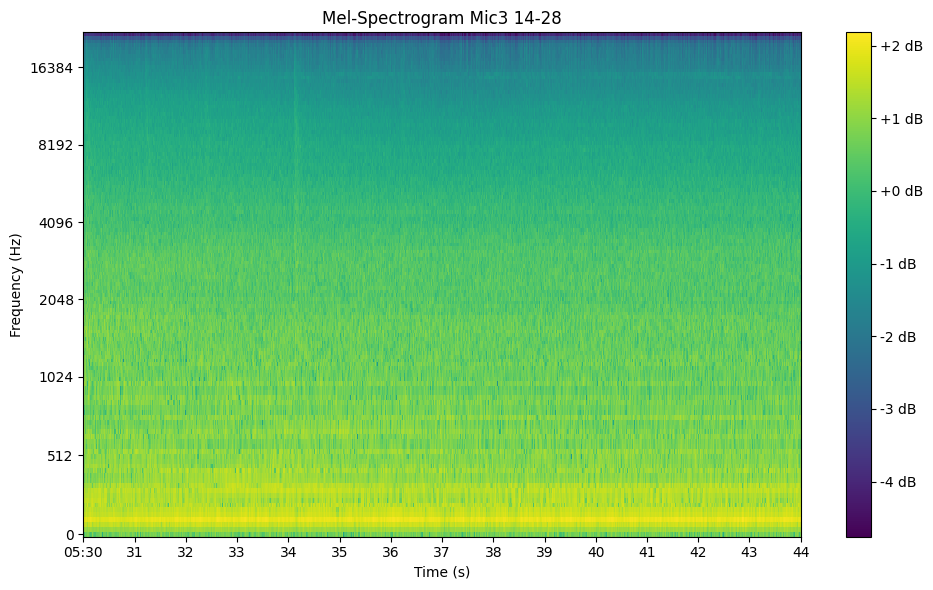

In [104]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Mic3 14-28', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([330, 344])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_8.png')
plt.show()

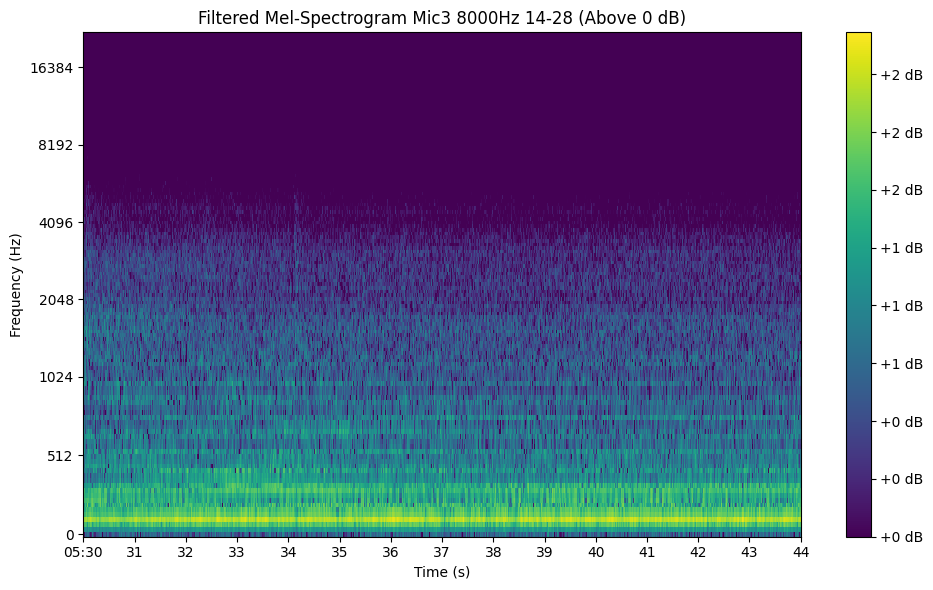

In [105]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax, vmin=0)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([330, 344])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img2, ax=ax, format='%+2.0f dB')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()

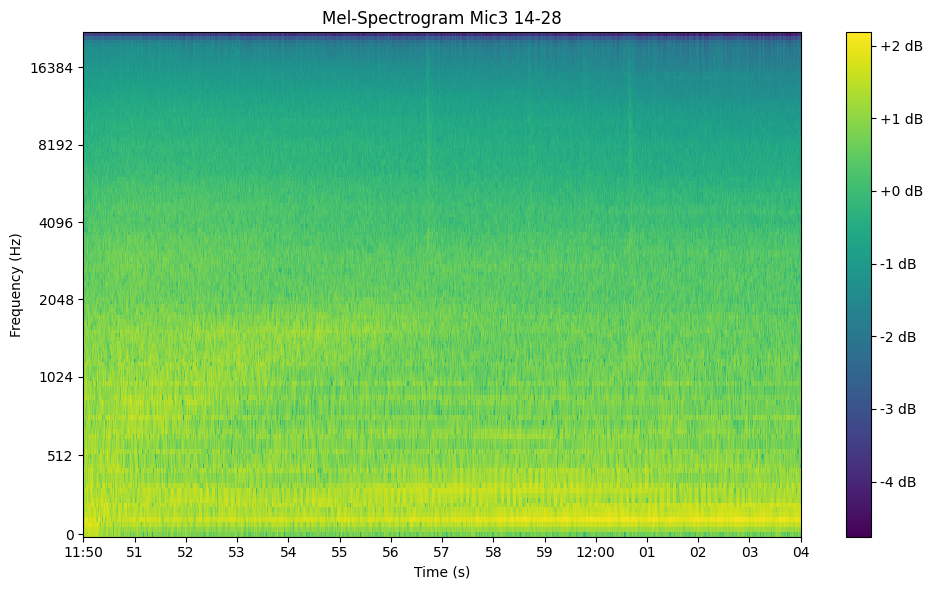

In [106]:
# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
ax.set(title='Mel-Spectrogram Mic3 14-28', xlabel='Time (s)', ylabel='Frequency (Hz)')

# Set the x-axis to display only specified part of spectrogram (in seconds)
ax.set_xlim([710, 724])

# Define a custom function to format the x-axis labels with MM:SS only at the beginning of each minute
def format_time(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    # Show "MM:SS" at the start of each new displayed minute, then only seconds
    if x == ax.get_xlim()[0] or seconds == 0:
        return f"{minutes:02d}:{seconds:02d}"
    else:
        return f"{seconds:02d}"

# Apply the formatter to the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set ticks at every 1 second
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Set color bar for dB scale
fig.colorbar(img1, ax=ax, format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_8.png')
plt.show()

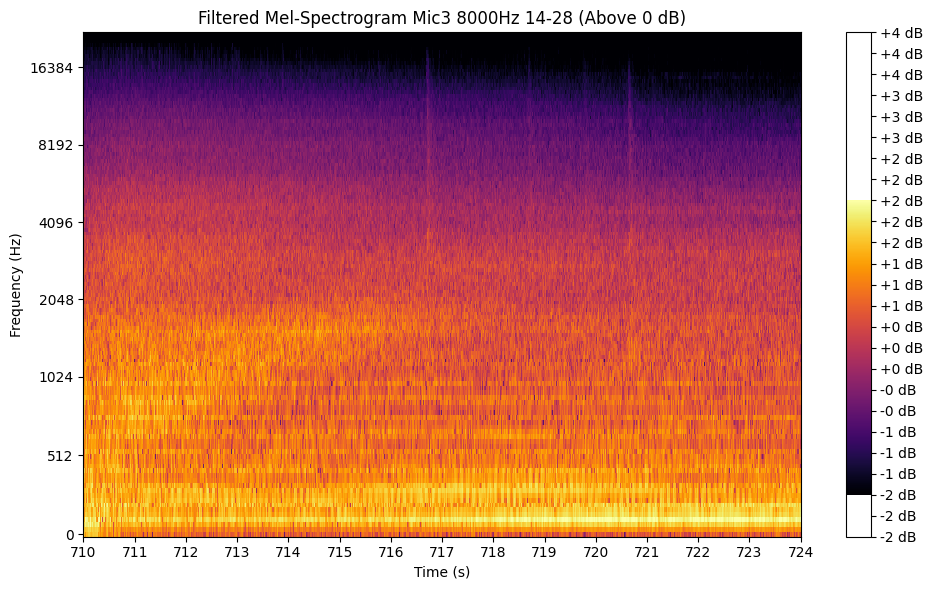

In [107]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock, sr=sr1, x_axis='time', y_axis='mel', cmap='inferno', ax=ax, vmin=-1.5, vmax=2)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([710, 724])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}"))

# Set color bar for dB scale
cbar = fig.colorbar(img2, ax=ax, format='%+2.0f dB')
cbar.set_ticks([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4])  # Add more tick marks for finer color gradation


# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()

In [108]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_knock_highHZ = librosa.feature.melspectrogram(S=np.abs(stft_knock), sr=sr1,fmin=2500 , n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_knock_highHZ = librosa.power_to_db(mel_knock_highHZ, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_knock_highHZ = (mel_db_knock_highHZ - np.mean(mel_db_knock_highHZ)) / np.std(mel_db_knock_highHZ)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_knock.npy", mel_db_knock_highHZ)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


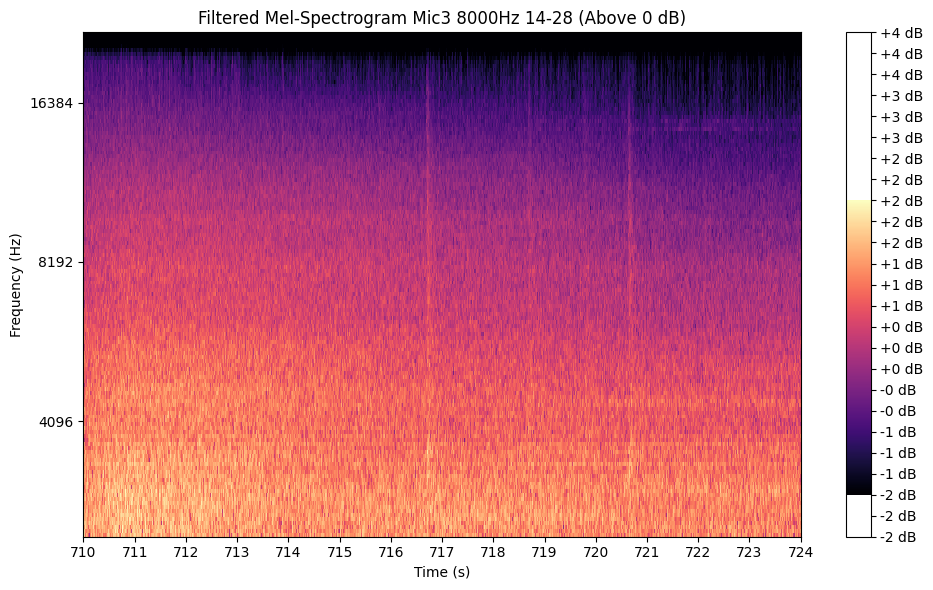

In [109]:
# Filter to display only sounds above +0 dB
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust the minimum dB level displayed by the color map
img2 = librosa.display.specshow(mel_db_knock_highHZ, sr=sr1, x_axis='time', y_axis='mel', cmap='magma', ax=ax, fmin=2500, vmin=-1.5, vmax=2)

# Set title, labels, and x-axis limits
ax.set(title='Filtered Mel-Spectrogram Mic3 8000Hz 14-28 (Above 0 dB)', xlabel='Time (s)', ylabel='Frequency (Hz)')
ax.set_xlim([710, 724])

# Apply the custom x-axis formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}"))

# Set color bar for dB scale
cbar = fig.colorbar(img2, ax=ax, format='%+2.0f dB')
cbar.set_ticks([-2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4])  # Add more tick marks for finer color gradation


# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig('../Data/mel/mel_spectrogram_mic3_ex_4_8000_filtered.png')
plt.show()